In [2]:
import xgboost as xgb
import geopandas as gpd
import os
import pandas as pd
import json
import importlib


embedding_config_path = '/home/christopher.x.ren/earth-index-ml/pipelines/batch/config/embeddings/nn/dino_vit_small_patch16_224_v02.py'
spec = importlib.util.spec_from_file_location("config", embedding_config_path)
config_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_module)
embeddings_config = config_module.config

bucket_name = embeddings_config['output_dir'].split('/')[2]
gcs_embeddings_dir = embeddings_config['output_dir']


def get_embeddings_path(mgrs_id: str, start_date: str, end_date: str) -> str:
    """Build full embeddings path for a given MGRS ID and date range
    
    Args:
        mgrs_id: MGRS tile identifier (e.g. "11SQA")
        start_date: Start date in YYYY-MM-DD format
        end_date: End date in YYYY-MM-DD format
    """
    dir_start = start_date.replace("-", "")
    dir_end = end_date.replace("-", "")
    date_range = f"{dir_start}-{dir_end}"
    fname = f"{mgrs_id}_{start_date}_{end_date}.parquet"
    return f"{embeddings_config['output_dir']}/{date_range}/{fname}"

embedding_config_path = '/home/christopher.x.ren/earth-index-ml/pipelines/batch/config/embeddings/nn/dino_vit_small_patch16_224_v02.py'
spec = importlib.util.spec_from_file_location("config", embedding_config_path)
config_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_module)
embeddings_config = config_module.config

bucket_name = embeddings_config['output_dir'].split('/')[2]
gcs_embeddings_dir = embeddings_config['output_dir']

with open('/home/christopher.x.ren/earth-index-ml/demeter/tea/config/ra_tea_aoi.json', 'r') as f:
    config = json.load(f)
mgrs_tiles = config['mgrs_ids']
ra_polys_chips = gpd.read_file("gs://demeter-labs/tea/geometries/chips_intersecting_ra_tea_polys_buf50_uu_exploded.geojson")
ra_polys_chips = ra_polys_chips.drop_duplicates(subset='tile_id')
ra_polys_chips['mgrs_id'] = [x[:5] for x in ra_polys_chips['tile_id']]
ra_polys_chips['label'] = 1
neg_chips = gpd.read_parquet("gs://demeter-labs/tea/samples/neg_esri_lc_cocoa_coffee_tiles.parquet")
neg_chips['label'] = 0

full_dataset = pd.concat([ra_polys_chips[['label', 'tile_id']], neg_chips[['label', 'tile_id', 'class']]])
full_dataset.loc[full_dataset['label'] == 1, "class"] = 'Tea'

## Use duckdb to get embeddings

In [3]:
# this might be faster if parallelized relative to duckdb, duckdb also appears to need around 60
# all_embeddings = []
# from tqdm import tqdm
# for mgrs_id in tqdm(full_dataset['mgrs_id'].unique()):
#     mgrs_gdf = full_dataset.loc[full_dataset['mgrs_id'] == mgrs_id]
#     embeddings = pd.read_parquet(get_embeddings_path(mgrs_id, '2023-01-01', '2024-01-01'))
#     filtered_embeddings = embeddings[embeddings['tile_id'].isin(mgrs_gdf['tile_id'])]
#     all_embeddings.append(filtered_embeddings)

import duckdb
conn = duckdb.connect('/home/christopher.x.ren/embeddings/ra_tea/embeddings.db')
conn.register('filter_df', full_dataset)

# Execute query using join instead of IN clause
pos_neg_embeddings = conn.execute("""
    SELECT e.*
    FROM embeddings e
    INNER JOIN filter_df f
    ON e.tile_id = f.tile_id
    ORDER BY e.row_number
""").df()

# Cleanup
duckdb.unregister('filter_df')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
embedding_dataset = pos_neg_embeddings.merge(full_dataset, on='tile_id', how='left')
embedding_dataset.to_parquet("gs://demeter-labs/tea/samples/ra_tea_embeddings_with_labels_v0.parquet")

In [5]:
# Get feature columns containing 'vit'
feature_cols = [col for col in embedding_dataset.columns if 'vit' in col]
X = embedding_dataset[feature_cols]
y = embedding_dataset['label']

# Stratified train test split based on class
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, 
    random_state=42,
    stratify=embedding_dataset['class']
)

# Train XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

# Get training and test accuracy
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")


Training accuracy: 0.999
Test accuracy: 0.972


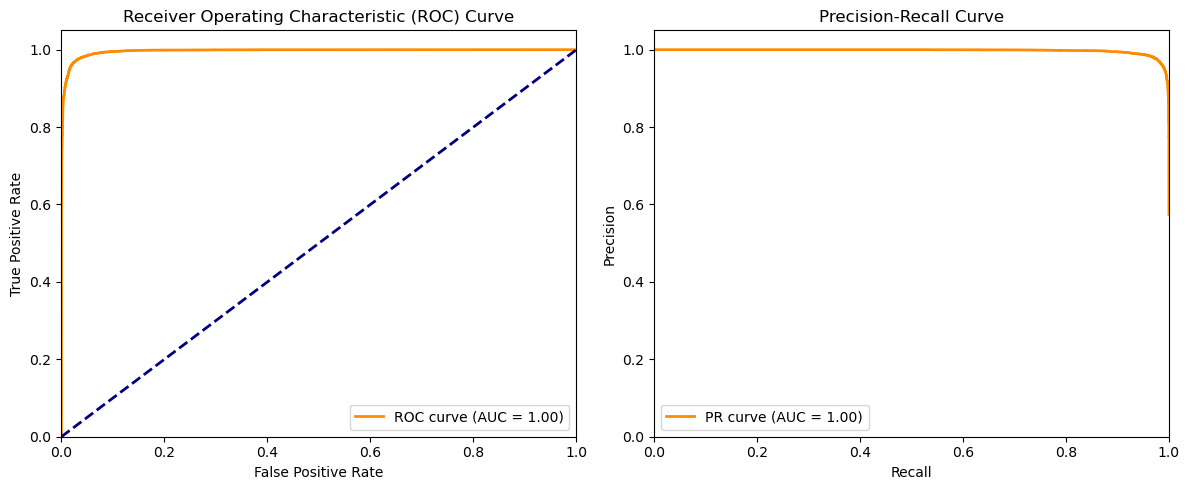

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics

# Get predictions and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Calculate ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

# Calculate PR curve
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
pr_auc = metrics.average_precision_score(y_test, y_pred_proba)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

# Plot PR curve
ax2.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")

plt.tight_layout()
plt.show()


In [6]:
# Close DuckDB connection and remove from memory
conn.close()



In [13]:
import glob
local_embedding_dir = "/home/christopher.x.ren/embeddings/ra_tea/embeddings"
files = glob.glob(f"{local_embedding_dir}/*.parquet")

In [14]:
test_df = pd.read_parquet(files[0])
test_df.head()

,vit-dino-patch16_0,vit-dino-patch16_1,vit-dino-patch16_2,vit-dino-patch16_3,vit-dino-patch16_4,vit-dino-patch16_5,vit-dino-patch16_6,vit-dino-patch16_7,vit-dino-patch16_8,vit-dino-patch16_9,...,vit-dino-patch16_375,vit-dino-patch16_376,vit-dino-patch16_377,vit-dino-patch16_378,vit-dino-patch16_379,vit-dino-patch16_380,vit-dino-patch16_381,vit-dino-patch16_382,vit-dino-patch16_383,tile_id
0,-1.754459,-0.337074,1.361862,3.201809,0.118858,0.322513,0.191307,-0.601855,0.123445,0.750958,...,0.841001,-0.955774,-0.206796,-0.135186,-1.357454,0.366293,-1.292899,1.178035,-1.905381,48MUB_32_16_10_0_0
1,-1.679468,-1.786984,1.181849,2.016942,0.453788,-0.170823,0.879103,0.477237,-0.308968,0.468714,...,0.761933,-0.244100,-0.459488,0.233937,-1.473886,0.400030,-0.128599,1.754810,-0.550493,48MUB_32_16_10_1_0
2,-1.888161,0.967090,-0.171676,0.895546,0.566005,-0.021056,0.478595,0.339083,-0.407932,0.611873,...,0.118759,-1.020813,-0.623420,0.520315,-2.029761,-0.270070,0.678796,1.328974,0.281497,48MUB_32_16_10_2_0
3,-0.266491,0.084587,-0.664072,1.038109,0.521913,-0.212439,1.025261,0.499949,-0.355663,1.479723,...,0.377453,0.060999,-0.542712,-0.331319,-2.073047,-0.012687,0.851107,0.623083,0.837371,48MUB_32_16_10_3_0
4,-0.429061,-1.287530,0.440435,2.527036,-0.642831,-1.245737,1.174242,0.290599,-0.064204,1.666353,...,-1.299020,0.737200,-0.735680,0.509507,-0.789703,-1.539523,-0.962385,0.023647,0.279444,48MUB_32_16_10_4_0


In [17]:
from tqdm import tqdm
import glob
import pandas as pd
from joblib import Parallel, delayed

def process_embedding_file(embedding_file, model):
    embeddings = pd.read_parquet(embedding_file)
    tile_ids = embeddings['tile_id']
    features = embeddings.drop(['tile_id', 'timestamp'], axis=1, errors='ignore')
    # Get model predictions
    proba = model.predict_proba(features)[:,1]
    # Filter for high confidence predictions
    high_conf_mask = proba > 0.5
    if high_conf_mask.any():
        high_conf_embeddings = pd.DataFrame({'tile_id': tile_ids[high_conf_mask]})
        high_conf_embeddings['prediction_probability'] = proba[high_conf_mask]
        return high_conf_embeddings
    return None

local_embedding_dir = "/home/christopher.x.ren/embeddings/ra_tea/embeddings"
embedding_files = glob.glob(f"{local_embedding_dir}/*.parquet")

predictions = Parallel(n_jobs=5, verbose=10)(
    delayed(process_embedding_file)(f, model) for f in embedding_files
)
predictions = [p for p in predictions if p is not None]

if predictions:
    prediction_df = pd.concat(predictions, ignore_index=True)

 24%|██▍       | 15/63 [00:04<00:15,  3.15it/s]/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   13.6s
/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/christopher.x.ren/miniforge3

In [32]:
prediction_df['mgrs_id'] = [x[:5] for x in prediction_df['tile_id']]
tiles_dir = "/home/christopher.x.ren/embeddings/ra_tea/tiles"
import geopandas as gpd
import pandas as pd
from joblib import Parallel, delayed

def process_mgrs_tile(mgrs_id, tiles_dir, prediction_df):
    matching_files = glob.glob(f"{tiles_dir}/*{mgrs_id}*.parquet")
    if not matching_files:
        return None
    
    tile_file = matching_files[0]
    tile_gdf = gpd.read_parquet(tile_file).to_crs(epsg=4326)
    tile_gdf = tile_gdf[tile_gdf['tile_id'].isin(prediction_df['tile_id'])]
    return tile_gdf

# Process tiles in parallel
tile_gdfs = Parallel(n_jobs=-1, verbose=10)(
    delayed(process_mgrs_tile)(mgrs_id, tiles_dir, prediction_df) 
    for mgrs_id in prediction_df['mgrs_id'].unique()
)

# Filter out None results and concatenate
tile_gdfs = [gdf for gdf in tile_gdfs if gdf is not None]
if tile_gdfs:
    tiles_gdf = pd.concat(tile_gdfs)
    positive_gdf = prediction_df.merge(tiles_gdf, on='tile_id')



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  11 out of  63 | elapsed:   13.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  63 | elapsed:   19.9s remaining:   49.7s
[Parallel(n_jobs=-1)]: Done  25 out of  63 | elapsed:   24.6s remaining:   37.4s
[Parallel(n_jobs=-1)]: Done  32 out of  63 | elapsed:   29.2s remaining:   28.3s
[Parallel(n_jobs=-1)]: Done  39 out of  63 | elapsed:   32.7s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done  46 out of  63 | elapsed:   38.0s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  53 out of  63 | elapsed:   42.1s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  60 out of  63 | elapsed:   46.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   47.7s finished


In [39]:
filtered_gdf = positive_gdf.loc[positive_gdf['prediction_probability'] > 0.999]

In [38]:
from lonboard import Map, ScatterplotLayer, PolygonLayer
from lonboard.colormap import apply_continuous_cmap
from matplotlib.cm import viridis
gdf = gpd.GeoDataFrame(filtered_gdf, geometry='geometry')
gdf['geometry'] = gdf['geometry'].centroid
layer = ScatterplotLayer.from_geopandas(
    gdf, get_radius=100, get_fill_color=apply_continuous_cmap(
        gdf['prediction_probability'].values, viridis
    ))
Map(layers=[layer])

/tmp/ipykernel_40864/1711378244.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].centroid


Map(layers=[ScatterplotLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7fcb59e54c40>
[
  [
  …

In [41]:
gpd.GeoDataFrame(positive_gdf, geometry='geometry').to_parquet(
    "gs://demeter-labs/tea/samples/ra_tea_positive_tiles_p0.5_v0.parquet")

In [43]:
filtered_gdf = positive_gdf.loc[positive_gdf['prediction_probability'] > 0.999]
gpd.GeoDataFrame(filtered_gdf, geometry='geometry').to_parquet(
    "gs://demeter-labs/tea/samples/ra_tea_positive_tiles_p0.999_v0.geojson")

In [55]:
filtered_gdf = positive_gdf.loc[positive_gdf['prediction_probability'] > 0.9999]
filtered_gdf = gpd.GeoDataFrame(filtered_gdf, geometry='geometry')
filtered_gdf = gpd.GeoDataFrame(geometry=[filtered_gdf.unary_union])
filtered_gdf.to_file("union_ra_tea_positive_tiles_p0.9999_v0.geojson")

/tmp/ipykernel_40864/1413554492.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  filtered_gdf = gpd.GeoDataFrame(geometry=[filtered_gdf.unary_union])
/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.13/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [ ]:

filtered_gdf = gpd.GeoDataFrame(filtered_gdf, geometry='geometry')
filtered_gdf.to_file("ra_tea_positive_tiles_p0.9995_v0.geojson")

In [51]:
filtered_gdf.to_file("ra_tea_positive_tiles_p0.9995_v0.geojson")